# Experiments with textual misinformation detection using machine learning models
Neste experimento, nós treinamos e testamos modelos de aprendizado de máquina para detecção de desinformação baseada puramente no texto. Nós avaliamos o desempenho de 5 modelos de classificação com ampla utilização em problemas de classificação de texto.

**Models:**
* Logistic regression
* Naive-Bayes
* SVM
* Random forest
* Multilayer Perceptron


In [1]:
import emoji, re, string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE 

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
base = 2018
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,0
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0


# Corpus statistics

In [3]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,282601.000000,282601.000000,282601.000000
mean,97.638688,14.962091,1.755716
std,407.238452,61.842076,5.122241
min,1.000000,1.000000,1.000000
25%,25.000000,4.000000,1.000000
50%,25.000000,4.000000,1.000000
75%,43.000000,7.000000,1.000000
max,65536.000000,5486.000000,91.000000


In [4]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


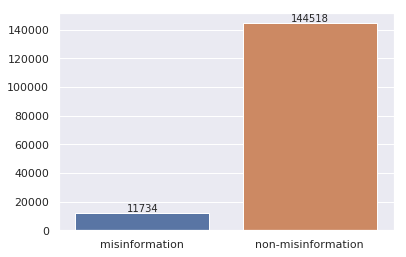

In [5]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


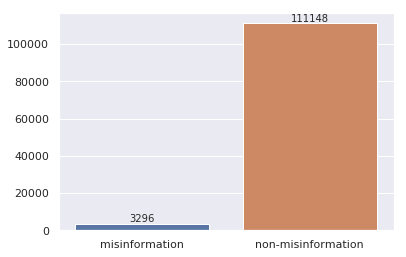

In [6]:
#removing duplicates
df = df.drop_duplicates(subset=['text'])
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

In [7]:
#emojis and punctuation
emoji_punct = list(emoji.UNICODE_EMOJI.keys()) + list(string.punctuation)
def processEmojisPunctuation(text):
    '''
    Put spaces between emojis and punctuation for unique tokens
    '''
    chars = set(text)
    for c in chars:
        if c in emoji_punct:
            text = text.replace(c, ' ' + c + ' ')
    text = text.replace('  ', ' ')
    return text

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    return text
            

In [8]:
texts = [preprocess(t) for t in texts]

## Train-test split

In [9]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.3, 
                                                                    stratify = y, random_state=42)

## TF-IDF vectorization and oversampling

In [10]:
#TF-IDF
vectorizer = TfidfVectorizer()
vectorizer.fit(texts_train)

X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [11]:
#oversampling with SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train.shape

(155606, 55504)

## Metrics

In [12]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

def getTestMetrics(y_test, y_pred, y_prob = []):
    '''
    Plot charts e print performance metrics
    Input: predictions and labels
    Output: charts and metrics
    '''
    print(metrics.classification_report(y_test, y_pred))
    
    f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average = 'macro')
    recall = metrics.recall_score(y_test, y_pred, average = 'macro')
    
    #confusion matrix
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    group_names = ['VN','FP','FN','VP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title('Confusion matrix')
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    roc_auc = 0

    if len(y_prob) > 0:
        #auroc
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: ',roc_auc)
        #plot
        #plt.figure()
        lw = 2
        plt.subplot(122)
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()
    return acc, precision, recall, f1, roc_auc

Logistic Regression


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.96      0.97     33345
           1       0.34      0.73      0.46       989

    accuracy                           0.95     34334
   macro avg       0.67      0.85      0.72     34334
weighted avg       0.97      0.95      0.96     34334

AUC:  0.9475701603528754


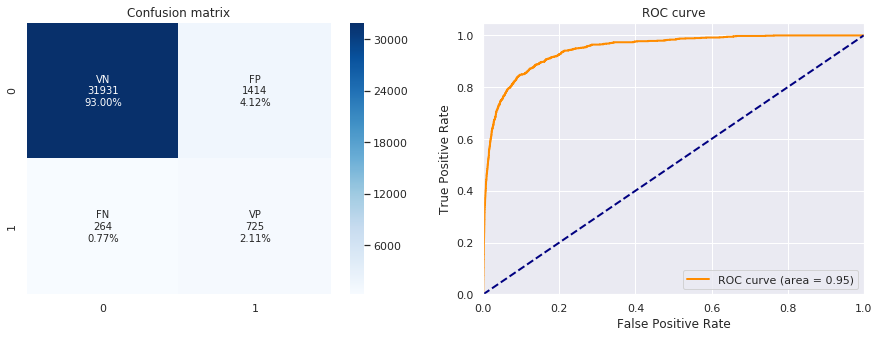

In [13]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Complement Naive-Bayes
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     33345
           1       0.10      0.79      0.18       989

    accuracy                           0.80     34334
   macro avg       0.55      0.79      0.53     34334
weighted avg       0.97      0.80      0.86     34334

AUC:  0.8727603276163758


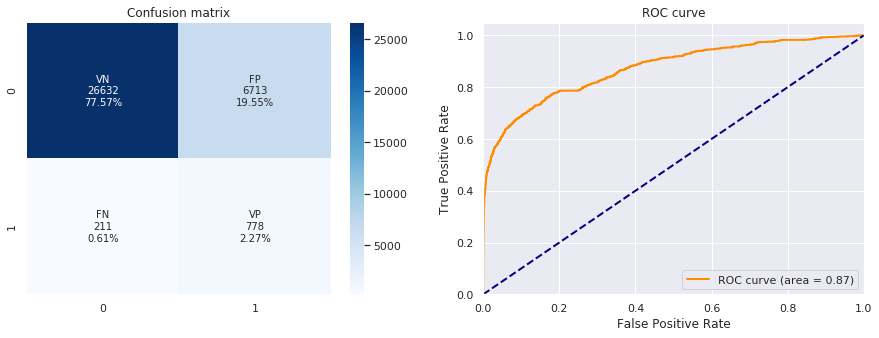

In [15]:
print('Complement Naive-Bayes')
cnb = ComplementNB().fit(X_train, y_train)
y_pred = cnb.predict(X_test)
y_prob = cnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('complement naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     33345
           1       0.37      0.36      0.36       989

    accuracy                           0.96     34334
   macro avg       0.67      0.67      0.67     34334
weighted avg       0.96      0.96      0.96     34334

AUC:  0.9108334883599638


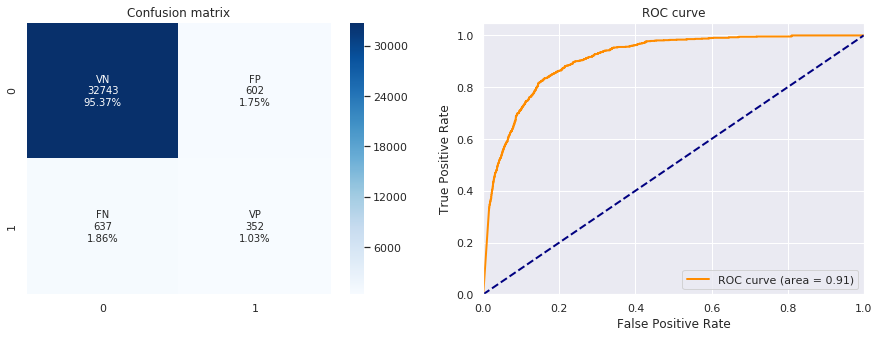

In [16]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     33345
           1       0.47      0.65      0.54       989

    accuracy                           0.97     34334
   macro avg       0.73      0.81      0.76     34334
weighted avg       0.97      0.97      0.97     34334



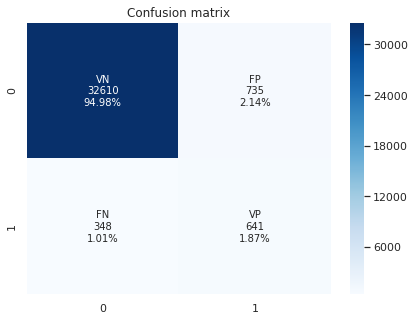

In [17]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multilayer perceptron


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33345
           1       0.58      0.58      0.58       989

    accuracy                           0.98     34334
   macro avg       0.79      0.78      0.78     34334
weighted avg       0.98      0.98      0.98     34334

AUC:  0.914214706349239


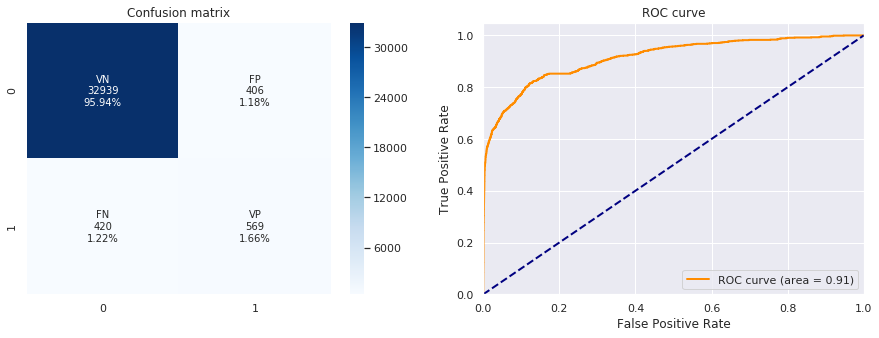

In [18]:
print('Multilayer perceptron')
mlp = MLPClassifier().fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33345
           1       0.80      0.54      0.65       989

    accuracy                           0.98     34334
   macro avg       0.89      0.77      0.82     34334
weighted avg       0.98      0.98      0.98     34334

AUC:  0.9514537859170928


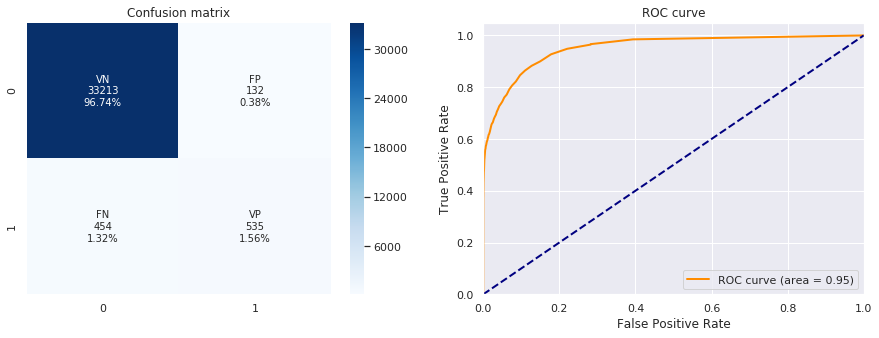

In [19]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [20]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})
df_metrics

,model,accuracy,precision,recall,f1 score,auc score
0,logistic regression,0.951127,0.665372,0.845329,0.718976,0.947570
1,multinomial naive-bayes,0.798334,0.547999,0.792667,0.534226,0.872760
2,complement naive-bayes,0.798334,0.547999,0.792667,0.534226,0.872760
3,bernoulli naive-bayes,0.963913,0.674945,0.668931,0.671879,0.910833
4,linear svm,0.968457,0.727642,0.813044,0.762869,0.000000
5,mlp,0.975942,0.785500,0.781576,0.783523,0.914215
6,random forest,0.982932,0.894307,0.768496,0.818695,0.951454


# Error examples with random forest

In [30]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('False negative: ',len(FN))
print('False positive: ',len(FP))

False negative:  454
False positive:  132


In [32]:
texts_FN = [texts_test[fn] for fn in FN]
texts_FP = [texts_test[fp] for fp in FP]

### False negative

In [33]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Toda essa historinha , segundo fonte ouvida no gabinete de um deputado PTista , poderia ser mera ficção se a quadrilha não divulgasse um vídeo , que pode ser o início desta armação . ricardochudo . blogspot . com
***
***
Ouçam e espalhem esse áudio , com explicações dos motivos de não ter greve de caminhoneiro . 👇 👇 
***
***
 * Direto de Caracas na Venezuela . 03 / 08 / 2017 * 

Assista o Vídeo : 
Cenas tristes da Venezuela . . . 
 . . . . . . . . . . . 
Milicianos dos movimentos sociais do governo , os unicos armados na Venezuela fazem assim :  Quando alguém vai reclamar do * Ditador Socialista * Maduro , apoiado por alguns malucos daqui . . . dentre eles a  * mFSP - máfia do Foro de São Paulo * , 
executam sumariamente os opositores ou manifestantes . 
 😢 😢 😢 😢 😢 

Divulgue , porque a imprensa do Brasil não está mostrando . . . 
 👇 👇 👇 👇 👇 👇 
***
***
 * Saberemos o resultado REAL das eleições no dia 11 / 10 / 18 . Missão operação antifraude 2018 direto dos EUA , pede que REPASSEM

### False positives

In [34]:
for fp in texts_FP:
    print('***')
    print(fp)
    print('***')

***
PETIÇÃO PÚBLICA PARA RETIRADA DA UFRJ DA ADMINISTRAÇÃO DO PALÁCIO IMPERIAL DA QUINTA DA BOA VISTA

Para recuperação e preservação do patrimônio histórico e cultural do Brasil . 

A UFRJ e os governos de , pelo menos , 30 anos , desde a redemocratização do país , vem tratando o Palácio Imperial da Quinta da Boa Vista e , por via de consequência o Museu Nacional , com descaso . Isso resultou no incêndio de todo o conjunto arquitetônico do Palácio Imperial e perda de mais de 90 % do acervo do Museu Nacional . 

Não podemos permitir que a reconstrução do palácio continue nas mãos de quem não tem o menor compromisso com a história do Brasil e história natural na América do Sul . 

A restauração tem que ser realizada , mas sob a administração de outra instituição , inclusive uma Fundação criada para este fim . 

Vamos tirar a UFRJ da Quinta da Boa Vista ! 

Esta petição foi criada por um cidadão ou uma organização independente de CitizenGO . Por essa razão , CitizenGO não é responsável p